# Advanced Gaussian sources

It can often be tedious to create easily usable customized simulation objects from scratch, as there are various details to consider. For instance, if one wants to create an easily-usable beam source from scratch, one must create functionality to automatically interpret the source plane into field coordinates, handle conversion for polar and azimuthal angles, handle different direction specifications, etc. This all becomes much more complicated to build than Tidy3D's natively supported Gaussian beam.
<br><br>
Fortunately, we can take advantage of the fact that Tidy3D is open source to create complex Gaussian sources without needing to consider any of these extraneous functionalities. Namely, we use the Tidy3D [BeamProfile](https://github.com/flexcompute/tidy3d/blob/develop/tidy3d/components/beam.py) class to handle all extra usability considerations, so we only need to define the scalar field profile for z being the propagation direction. The BeamProfile object will automatically rotate the field amplitudes according to the geometry of the source plane and specified angles.
<br><br>
This is just one way in which we can take advantage of the open source nature of Tidy3D, and these principles can be applied to any base object class that Tidy3D provides.

In [1]:
# Standard python imports
import matplotlib.pyplot as plt
import numpy as np

# Tidy3D import
import tidy3d as td
from tidy3d import web

# Import base object
from tidy3d.components.beam import BeamProfile

## Quasi Gaussian source

Here we show how to create a Quasi-Gaussian mode in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object, based on [J. Tuovinen, 1992](https://ieeexplore.ieee.org/document/138840). When a small beam waist (on the order of a wavelength or smaller) is required, this source is a better solution to the full-wave equation as opposed to the paraxial wave equation:

<center>$E(r,z) = \frac{w_0}{w(z)}\frac{1}{{F^{\prime\prime}}^2}\exp{\lparen(-\frac{(r/F^{\prime\prime})^2}{w(z)^2} - jkz - jkR(z)(F^{\prime\prime} - 1) + j\phi_0}\rparen)$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$\omega(z)=\omega_0\sqrt{1+\frac{z^2}{z_R^2}}$ is the beam radius</li>
<li>$R(z)=z(1+\frac{z_R^2}{z^2})$ is the wavefront curvature</li>
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$F^{\prime\prime}=[1 + (r/R(z))^2]^{0.5}$</li>
<li>$\phi_0(z)=\arctan{\left(\frac{z}{z_R}\right)}$ is the phase shift</li>

<br>
We then validate the field profile along the propagation direction.

In [2]:
def QuasiGaussian(
    size,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class QuasiGaussian_obj(BeamProfile):
        """Component for constructing OAM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for OAM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z -= waist_distance
            r = np.sqrt(x**2 + y**2)

            k = 2 * np.pi * np.array(freqs) / td.C_0 * background_n
            zR = np.real(w0**2 * k / 2)
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            inv_Rz = z / (z**2 + zR**2)
            Fpp = np.sqrt(1 + r**2 * inv_Rz**2)
            phi0 = np.arctan2(z, zR)

            phase = -((r / Fpp) ** 2) / wz**2 - 1j * k * z + 1j * phi0
            if np.all(inv_Rz) != 0:
                phase -= 1j * k * (Fpp - 1) / inv_Rz

            E = w0 / wz * 1 / Fpp**2 * np.exp(phase)

            return E

    QuasiGaussian_obj = QuasiGaussian_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = QuasiGaussian_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    QuasiGaussian_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return QuasiGaussian_source

In [3]:
freq0 = td.C_0 / 0.5

QG_center = (0, 0, -5)
QG_size = (5, 5, 0)
QG_source_time = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
QG_w0 = td.C_0 / freq0 / 5
QG_waist_distance = -5

QG_source = QuasiGaussian(
    center=QG_center,
    size=QG_size,
    source_time=QG_source_time,
    w0=QG_w0,
    waist_distance=QG_waist_distance,
)

G_source = td.GaussianBeam(
    center=QG_center,
    size=QG_size,
    source_time=QG_source_time,
    direction="+",
    waist_radius=QG_w0,
    waist_distance=QG_waist_distance,
)

In [4]:
field = td.FieldMonitor(
    size=(td.inf, 0, td.inf), name="field", freqs=[freq0 * 0.9, freq0, freq0 * 1.1]
)

QG_sim = td.Simulation(
    size=(5, 5, 15), sources=[QG_source], structures=[], monitors=[field], run_time=50 / freq0
)

G_sim = QG_sim.updated_copy(sources=[G_source])

In [5]:
QG_sim_data = web.run(simulation=QG_sim, task_name="gaussian beam profile test")
G_sim_data = web.run(simulation=G_sim, task_name="gaussian beam profile test")

12:46:25 EDT Created task 'gaussian beam profile test' with task_id             
             'fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=286678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=736367;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\taskId]8;;\]8;id=286678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\=]8;;\]8;id=416981;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\fdve]8;;\]8;id=286678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\-c1a4c23a-8a6]8;;\
             ]8;id=286678;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\2-4089-89d8-ae6dc5ff265a']8;;\.

             Task folder: ]8;id=263120;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:46:29 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:46:30 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:51:29 EDT status = preprocess

12:51:34 EDT starting up solver

             running solver

Output()

             early shutoff detected at 84%, exiting.

             status = postprocess

Output()

12:51:37 EDT status = success

12:51:39 EDT View simulation result at                                          
             ]8;id=293260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=82088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\taskId]8;;\]8;id=293260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\=]8;;\]8;id=835031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\fdve]8;;\]8;id=293260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\-c1a4c23a-8a6]8;;\
             ]8;id=293260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c1a4c23a-8a62-4089-89d8-ae6dc5ff265a\2-4089-89d8-ae6dc5ff265a']8;;\.

Output()

12:51:40 EDT loading simulation from simulation_data.hdf5

12:51:41 EDT Created task 'gaussian beam profile test' with task_id             
             'fdve-d5966b95-2327-4cdc-8bba-83ef375fb381' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=856181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=970905;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\taskId]8;;\]8;id=856181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\=]8;;\]8;id=793044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\fdve]8;;\]8;id=856181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\-d5966b95-232]8;;\
             ]8;id=856181;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\7-4cdc-8bba-83ef375fb381']8;;\.

             Task folder: ]8;id=628002;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:51:42 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:51:51 EDT starting up solver

             running solver

Output()

12:51:52 EDT early shutoff detected at 84%, exiting.

             status = postprocess

Output()

12:51:54 EDT status = success

12:51:56 EDT View simulation result at                                          
             ]8;id=760498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=243219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\taskId]8;;\]8;id=760498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\=]8;;\]8;id=605615;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\fdve]8;;\]8;id=760498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\-d5966b95-232]8;;\
             ]8;id=760498;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d5966b95-2327-4cdc-8bba-83ef375fb381\7-4cdc-8bba-83ef375fb381']8;;\.

Output()

12:51:58 EDT loading simulation from simulation_data.hdf5

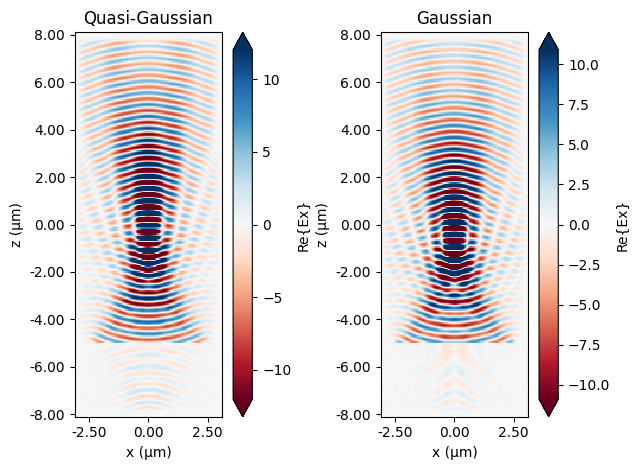

In [6]:
fig, ax = plt.subplots(1, 2)

QG_sim_data.plot_field(field_monitor_name="field", field_name="Ex", f=freq0, ax=ax[0])
G_sim_data.plot_field(field_monitor_name="field", field_name="Ex", f=freq0, ax=ax[1])
ax[0].set_title("Quasi-Gaussian")
ax[1].set_title("Gaussian")
plt.tight_layout()
plt.show()

## Hermite-Gaussian source

Here we show how to create a Hermite-Gaussian mode in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the phase change along the propagation direction.<br><br>
In cartesian coordinates, where $x$ is the propagation direction, the OAM has field profile

<center>$E_{l,m}(x,y,z)=E_0\frac{\omega_0}{\omega(z)}H_l\lparen\frac{\sqrt{2}x}{\omega(z)}\rparen H_m\lparen\frac{\sqrt{2}y}{\omega(z)}\rparen\exp\lparen-\frac{x^2+y^2}{\omega^2(z)}\rparen\exp\lparen-i\frac{k(x^2+y^2)}{2R(z)}\rparen\exp\lparen i\psi(x)\rparen\exp\lparen -ikz\rparen$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$\omega(z)=\omega_0\sqrt{1+\frac{z^2}{z_R^2}}$ is the beam radius</li>
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$R(z)=z(1+\frac{z_R^2}{z^2})$ is the wavefront curvature</li>
<li>$H_l,H_m$ are Hermite polynomials of orders $l$ and $m$</li>
<li>$\psi(z)=(l+m+1)\arctan\lparen\frac{z}{z_R}\rparen$ is the phase function</li>

In [7]:
from scipy.special import hermite


def HGM(
    size,
    m,
    l,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class HGM_obj(BeamProfile):
        """Component for constructing HGM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for HGM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance

            zR = np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs))
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            Rz = td.inf if np.any(z == 0) else z * (1 + zR**2 / z**2)
            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            psi_z = (l + m + 1) * np.arctan2(z, np.real(zR))

            E = source_time.amplitude * w0 / wz
            E *= hermite(l)(np.real(np.sqrt(2) * x / wz)) * hermite(m)(np.real(np.sqrt(2) * y / wz))
            E *= np.exp(-(x**2 + y**2) / wz**2) * np.exp(-1j * k * (x**2 + y**2) / (2 * Rz))
            E *= np.exp(1j * psi_z) * np.exp(-1j * k * z)

            return E

    HGM_obj = HGM_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = HGM_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    HGM_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return HGM_source

Create and run example Hermite-Gaussian beam:

In [8]:
freq0 = td.C_0 / 1.55
hgm = HGM(size=(0, 4, 4), m=2, l=1, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10))

In [9]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

HGM_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[hgm],
    monitors=field_monitors,
    run_time=1e-13,
)

In [10]:
hgm_sim_data = web.run(simulation=HGM_test_sim, task_name="HGM test")

12:51:59 EDT Created task 'HGM test' with task_id                               
             'fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=754901;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=679402;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\taskId]8;;\]8;id=754901;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\=]8;;\]8;id=534854;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\fdve]8;;\]8;id=754901;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\-2bec5be6-3f3]8;;\
             ]8;id=754901;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\9-42c1-8002-c7226efd01ef']8;;\.

             Task folder: ]8;id=453885;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:52:01 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:52:02 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:52:34 EDT starting up solver

             running solver

Output()

12:52:37 EDT early shutoff detected at 92%, exiting.

12:52:38 EDT status = postprocess

Output()

12:52:44 EDT status = success

12:52:46 EDT View simulation result at                                          
             ]8;id=32310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=634024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\taskId]8;;\]8;id=32310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\=]8;;\]8;id=216390;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\fdve]8;;\]8;id=32310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\-2bec5be6-3f3]8;;\
             ]8;id=32310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bec5be6-3f39-42c1-8002-c7226efd01ef\9-42c1-8002-c7226efd01ef']8;;\.

Output()

12:52:48 EDT loading simulation from simulation_data.hdf5

Display field in propagation direction:

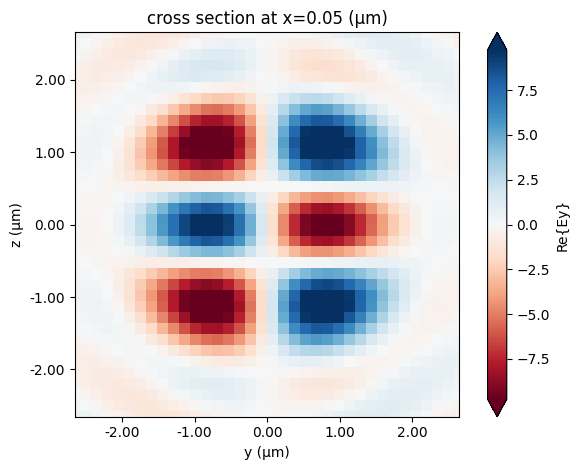

In [11]:
hgm_sim_data.plot_field(str(field_monitor_xs[0]), "Ey", f=freq0)
plt.show()

To see how the field evolves, run the following code to visualize along the propagation direction.

In [12]:
import ipywidgets as widgets

component = "Ey"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    hgm_sim_data.plot_field(str(x), component, f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='Ey', max=5.0, min=0.0500000000000001…

## Laguerre-Gaussian source

Here we show how to create an Orbital Angular Momentum (OAM) beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the phase change along the propagation direction.<br><br>
In cylindrical coordinates, where $z$ is the propagation direction, the OAM has field profile

<center>$E_{l,p}(r,\phi,z)=E_0\sqrt{\frac{2p!}{\pi(p+|l|)!}} \frac{1}{\omega(z)} \lparen\frac{r\sqrt{2}}{\omega(z)}\rparen^{|l|} \exp\lparen-\frac{r^2}{\omega^2(z)}\rparen L_p^{|l|}\lparen\frac{2r^2}{\omega^2(z)}\rparen \exp\lparen-ik\frac{r^2}{2R(z)}\rparen \exp\lparen-il\phi\rparen \exp\lparen i\psi(z)\rparen$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$\omega(z)=\omega_0\sqrt{1+\frac{z^2}{z_R^2}}$ is the beam radius</li>
<li>$R(z)=z(1+\frac{z_R^2}{z^2})$ is the wavefront curvature</li>
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$L_p^{|l|}$ is the generalized Laguerre polynomial</li>
<li>$\psi(z)=(|l| + 2p + 1)\arctan\lparen\frac{z}{z_R}\rparen$ is the phase function</li>

In [13]:
from scipy.special import factorial, genlaguerre


def OAM(
    size,
    p,
    l,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    freqs = [source_time.freq0]

    class OAM_obj(BeamProfile):
        """Component for constructing OAM beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for OAM beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)
            absl = np.abs(l)

            zR = np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs))
            wz = w0 * np.sqrt(1 + z**2 / zR**2)
            Rz = td.inf if np.any(z == 0) else z * (1 + zR**2 / z**2)
            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            psi_z = (np.abs(l) + 2 * p + 1) * np.arctan2(z, np.real(zR))

            E = genlaguerre(p, absl)(2 * r**2 / wz**2) if p != 0 else 1
            E *= (
                source_time.amplitude
                * np.sqrt(2 * factorial(p) / (np.pi * factorial(p + absl)))
                / wz
            )
            E *= (r * np.sqrt(2) / wz) ** absl * np.exp(-(r**2) / wz**2)
            E *= np.exp(-1j * k * r**2 / (2 * Rz)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)

            return E

    OAM_obj = OAM_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = OAM_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    OAM_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return OAM_source

We will demonstrate this functionality by defining an OAM source that propagates in the $x$ direction.

In [14]:
freq0 = td.C_0 / 1.55
oam = OAM(size=(0, 4, 4), p=0, l=1, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10))

In [15]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

OAM_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[oam],
    monitors=field_monitors,
    run_time=1e-13,
)

In [16]:
oam_sim_data = web.run(simulation=OAM_test_sim, task_name="OAM test")

12:52:49 EDT Created task 'OAM test' with task_id                               
             'fdve-820d58dc-7a6f-41df-bbda-3914f509d04e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=751494;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=599608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\taskId]8;;\]8;id=751494;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\=]8;;\]8;id=898319;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\fdve]8;;\]8;id=751494;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\-820d58dc-7a6]8;;\
             ]8;id=751494;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\f-41df-bbda-3914f509d04e']8;;\.

             Task folder: ]8;id=492362;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:52:51 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:52:52 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:52:59 EDT starting up solver

             running solver

Output()

12:53:02 EDT early shutoff detected at 92%, exiting.

             status = postprocess

Output()

12:53:09 EDT status = success

12:53:11 EDT View simulation result at                                          
             ]8;id=384580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=879865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\taskId]8;;\]8;id=384580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\=]8;;\]8;id=782153;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\fdve]8;;\]8;id=384580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\-820d58dc-7a6]8;;\
             ]8;id=384580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-820d58dc-7a6f-41df-bbda-3914f509d04e\f-41df-bbda-3914f509d04e']8;;\.

Output()

12:53:12 EDT loading simulation from simulation_data.hdf5

Display field in propagation direction:

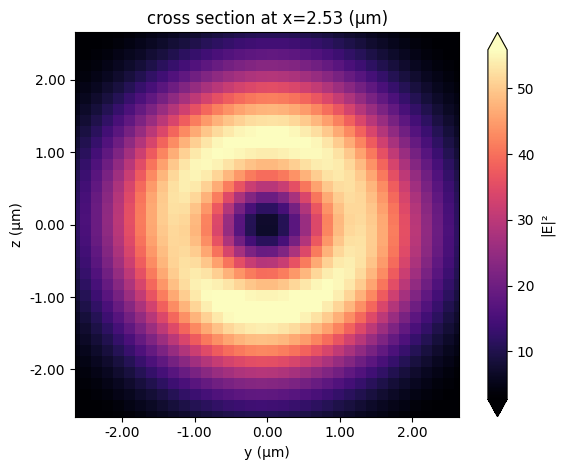

In [17]:
oam_sim_data.plot_field(str(field_monitor_xs[30]), "E", f=freq0, val="abs^2")
plt.show()

To see how the field amplitude evolves, run the following code to visualize along the propagation direction.

In [18]:
import ipywidgets as widgets

component = "Ey"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    oam_sim_data.plot_field(str(x), component, f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='Ey', max=5.0, min=0.0500000000000001…

## Bessel Beam

Here we show how to create an Bessel beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the phase change along the propagation direction.<br><br>
In cylindrical coordinates $(\rho, \phi, z)$, where $z$ is the propagation direction, the Bessel beam has field profile

<center>$U_\beta(r)=J_m(k_T\rho)e^{im\phi}e^{-i\beta z}$</center>

where:
<li>$k=\frac{2\pi n}{\lambda}$ is the wavenumber</li>
<li>$J_m$ is the Bessel function of the first kind and $m^{th}$ order</li>
<li>$k_T=\sqrt{k^2-\beta^2}$</li>
<br>
Source: Saleh & Teich, <i>Fundamentals of Photonics</i>

In [19]:
from scipy.special import jv


def Bessel(
    size,
    m,
    beta,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    if not isinstance(m, int):
        raise Exception("Error: m must be an integer")
    freqs = [source_time.freq0]

    class Bessel_obj(BeamProfile):
        """Component for constructing Bessel beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for Bessel beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance
            rho = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y, x)
            beta % (2 * np.pi)

            k = 2 * np.pi * np.array(self.freqs) / td.C_0 * background_n
            k_T = np.sqrt(k**2 - beta**2)

            E = source_time.amplitude * jv(m, k_T * rho)
            E *= np.exp(1j * m * phi) * np.exp(-1j * beta * z)

            return E

    Bessel_obj = Bessel_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = Bessel_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    Bessel_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return Bessel_source

Create and run example Bessel beam:

In [20]:
freq0 = td.C_0 / 1.55
bessel = Bessel(
    size=(0, 4, 4), m=0, beta=0, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
)

In [21]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

Bessel_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[bessel],
    monitors=field_monitors,
    run_time=1e-13,
)

In [22]:
bessel_sim_data = web.run(simulation=Bessel_test_sim, task_name="Bessel test")

12:53:13 EDT Created task 'Bessel test' with task_id                            
             'fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=408503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=382460;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\taskId]8;;\]8;id=408503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\=]8;;\]8;id=544792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\fdve]8;;\]8;id=408503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\-5dab88b6-5fc]8;;\
             ]8;id=408503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\e-4a42-b16d-d2d972bfb94d']8;;\.

             Task folder: ]8;id=866883;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:53:16 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:53:17 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:53:40 EDT status = preprocess

12:53:45 EDT starting up solver

             running solver

Output()

             early shutoff detected at 92%, exiting.

             status = postprocess

Output()

12:53:52 EDT status = success

12:53:54 EDT View simulation result at                                          
             ]8;id=729366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=259142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\taskId]8;;\]8;id=729366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\=]8;;\]8;id=792469;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\fdve]8;;\]8;id=729366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\-5dab88b6-5fc]8;;\
             ]8;id=729366;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5dab88b6-5fce-4a42-b16d-d2d972bfb94d\e-4a42-b16d-d2d972bfb94d']8;;\.

Output()

12:53:56 EDT loading simulation from simulation_data.hdf5

Display field amplitude in propagation direction:

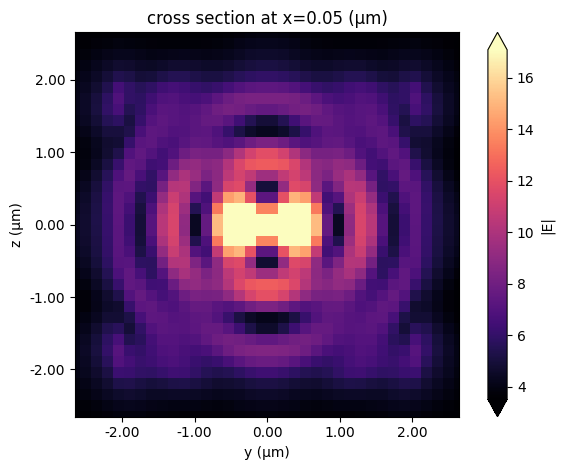

In [23]:
bessel_sim_data.plot_field(str(field_monitor_xs[0]), "E", val="abs", f=freq0)
plt.show()

To see how the field amplitude evolves, run the following code to visualize along the propagation direction.

In [24]:
import ipywidgets as widgets

component = "E"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    bessel_sim_data.plot_field(str(x), component, val="abs", f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='E', max=5.0, min=0.05000000000000018…

## Hyper-geometric Gaussian modes

Here we show how to create a Hyper-geometric Gaussian (HGG) beam in Tidy3D using our [CustomFieldSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomFieldSource.html) object. We then validate the phase change along the propagation direction.<br><br>
In cylindrical coordinates, where $\rho=\frac{r}{\omega_0}$ is the normalized radial coordinate and $Z=\frac{z}{z_R}$ is the normalized longitude direction (the direction of propagation), the HGG has field profile

<center>$E_{p,m}\lparen\rho,\phi,Z\rparen=\sqrt{\frac{2^{p+|m|+1}}{\pi\Gamma(p+|m|+1)}}\frac{\Gamma\lparen\frac{p}{2}+|m|+1\rparen}{\Gamma(|m|+1)}i^{|m|+1}Z^{\frac{p}{2}}\lparen Z+i\rparen^{-\lparen\frac{p}{2}+|m|+1\rparen}\rho^{|m|}\exp\lparen-\frac{i\rho^2}{Z+i}\rparen e^{im\phi} {_1}F_1\lparen-\frac{p}{2},|m|+1;\frac{\rho^2}{Z(Z+i)}\rparen$</center>

where:
<li>$\omega_0$ is the beam waist</li>
<li>$z_R=\frac{\pi n_\epsilon\omega_0^2}{\lambda}$ is the Rayleigh length</li>
<li>$m$ is the rotational index</li>
<li>$p\geq-|m|$</li>
<li>$\Gamma(x)$ is the gamma function</li>
<li>${_1}F_1(a,b;x)$ is a confluent hypergeometric function</li>

In [25]:
from scipy.special import gamma, hyp1f1


def HGG(
    size,
    p,
    m,
    source_time,
    center=(0, 0, 0),
    direction="+",
    pol_angle=0,
    angle_phi=0,
    angle_theta=0,
    w0=1,
    waist_distance=0,
):
    if p < -np.abs(m):
        raise Exception("Error: p must be greater than or equal to -|m|")
    freqs = [source_time.freq0]

    class HGG_obj(BeamProfile):
        """Component for constructing HGG beam data. The normal direction is implicitly
        defined by the ``size`` parameter.
        """

        def scalar_field(self, points, background_n):
            """Scalar field for HGG beam.
            Scalar field corresponding to the analytic beam in coordinate system such that the
            propagation direction is z and the ``E``-field is entirely ``x``-polarized. The field is
            computed on an unstructured array ``points`` of shape ``(3, ...)``.
            """
            x, y, z = points
            z += waist_distance

            r = np.sqrt(x**2 + y**2) / w0
            phi = np.arctan2(y, x)
            abs_m = np.abs(m)

            E = source_time.amplitude * np.sqrt(
                2 ** (p + abs_m + 1) / (np.pi * gamma(p + abs_m + 1))
            )

            Z = z / (np.pi * background_n * w0**2 / (td.C_0 / np.array(self.freqs)))
            if np.all(Z) == 0:
                return E * r ** (p + abs_m) * np.exp(-(r**2) + 1j * m * phi)

            E *= gamma(p / 2 + abs_m + 1) / gamma(abs_m + 1) * 1j ** (abs_m + 1) * Z ** (p / 2)
            E *= (Z + 1j) ** (-(p / 2 + abs_m + 1)) * r**abs_m * np.exp(-(1j * r**2) / (Z + 1j))
            E *= np.exp(1j * m * phi) * hyp1f1(-p / 2, abs_m + 1, r**2 / (Z * (Z + 1j)))

            return E

    HGG_obj = HGG_obj(
        center=center,
        size=size,
        freqs=freqs,
        angle_theta=angle_theta,
        angle_phi=angle_phi,
        pol_angle=pol_angle,
        direction=direction,
    )
    field_data = HGG_obj.field_data
    field_dataset = td.FieldDataset(
        Ex=field_data.Ex,
        Ey=field_data.Ey,
        Ez=field_data.Ez,
        Hx=field_data.Hx,
        Hy=field_data.Hy,
        Hz=field_data.Hz,
    )
    HGG_source = td.CustomFieldSource(
        center=center, size=size, source_time=source_time, field_dataset=field_dataset
    )
    return HGG_source

Create and run example HGG beam:

In [26]:
freq0 = td.C_0 / 1.55
hgg = HGG(size=(0, 4, 4), p=1, m=2, source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10))

In [27]:
sim_size = (5.1, 5, 5)
sim_center = (sim_size[0] / 2 - 0.05, 0, 0)

num_field_monitors = 61
field_monitor_xs = np.linspace(
    sim_center[0] - sim_size[0] / 2 + 0.1, sim_size[0] - 0.1, num_field_monitors
)
field_monitors = []
for x in field_monitor_xs:
    field_monitor = td.FieldMonitor(
        center=(x, 0, 0), size=(0, sim_size[1], sim_size[2]), name=str(x), freqs=[freq0]
    )
    field_monitors.append(field_monitor)

HGG_test_sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    structures=[],
    sources=[hgg],
    monitors=field_monitors,
    run_time=1e-13,
)

In [28]:
hgg_sim_data = web.run(simulation=HGG_test_sim, task_name="HGG test")

12:53:57 EDT Created task 'HGG test' with task_id                               
             'fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=644154;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=722876;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\taskId]8;;\]8;id=644154;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\=]8;;\]8;id=154727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\fdve]8;;\]8;id=644154;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\-49fb8c4d-8ef]8;;\
             ]8;id=644154;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\f-42e5-9cb9-ec56578a6933']8;;\.

             Task folder: ]8;id=543946;https://tidy3d.simulation.cloud/folders/ee7143f0-3861-47de-ae8f-8f55df7232f1\'default']8;;\.

Output()

12:53:59 EDT Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

12:54:00 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:54:09 EDT starting up solver

             running solver

Output()

             early shutoff detected at 92%, exiting.

             status = postprocess

Output()

12:54:18 EDT status = success

12:54:20 EDT View simulation result at                                          
             ]8;id=839853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=911920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\taskId]8;;\]8;id=839853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\=]8;;\]8;id=862695;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\fdve]8;;\]8;id=839853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\-49fb8c4d-8ef]8;;\
             ]8;id=839853;https://tidy3d.simulation.cloud/workbench?taskId=fdve-49fb8c4d-8eff-42e5-9cb9-ec56578a6933\f-42e5-9cb9-ec56578a6933']8;;\.

Output()

12:54:22 EDT loading simulation from simulation_data.hdf5

Display field in propagation direction:

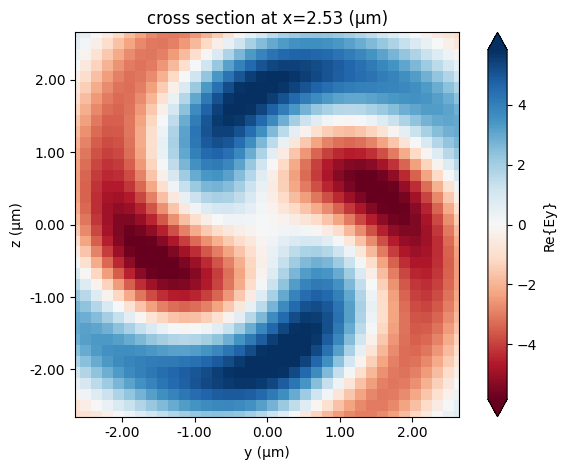

In [29]:
hgg_sim_data.plot_field(str(field_monitor_xs[30]), "Ey", f=freq0)
plt.show()

To see how the field evolves, run the following code to visualize along the propagation direction.

In [30]:
import ipywidgets as widgets

component = "Ey"

field_slider = widgets.FloatSlider(
    value=0,
    min=field_monitor_xs[0],
    max=field_monitor_xs[-1],
    step=None,
    description=component,
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".3f",
)


def update_plot(x):
    if x not in field_monitor_xs:
        x = min(field_monitor_xs, key=lambda ll: abs(ll - x))
    hgg_sim_data.plot_field(str(x), component, f=freq0)
    plt.show()


widgets.interactive(update_plot, x=field_slider)

interactive(children=(FloatSlider(value=0.05000000000000018, description='Ey', max=5.0, min=0.0500000000000001…